In [1]:
!pip install wandb pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [2]:
import warnings
import math
import wandb
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date, timedelta
from datetime import datetime
from collections import defaultdict
from pmdarima.arima import auto_arima, AutoARIMA
from pmdarima.arima.utils import ndiffs
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer, LogEndogTransformer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.options.display.max_rows = 500
warnings.filterwarnings('ignore')

In [3]:
def plot_features(df, cols, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    df.set_index('Date').plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    plt.legend(cols)
    plt.axhline(0, linestyle='--', color='k', alpha=0.3)
    plt.show()

In [4]:
def adfuller_test(ip_dict, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    def adjust(val, length=6): return str(val).ljust(length)
    res = pd.DataFrame()
    for key in ip_dict.keys():
        series = ip_dict[key][name]
        r = adfuller(series, autolag='AIC')
        output = {
            'column': key,
            'signif': signif,
            'test_statistic': round(r[0], 4),
            'n_obs': r[3],
            'pvalue': round(r[1], 4),
            'n_lags': round(r[2], 4)
        }

        p_value = output['pvalue']
        for key, val in r[4].items():
            output[f'critical value {adjust(key)}'] = round(val, 3)

        if p_value <= signif:
            output['stationary'] = True
        else:
            output['stationary'] = False

        res = pd.concat([res, pd.DataFrame(output, index=[0])], axis=0)
    return res

In [6]:
# Read the datasets
data = pd.read_csv("./data/train.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

In [7]:
# Concatecate `StateCode` and `StationId` with '-' as separator
data["StateStation"] = data["StateCode"] + "_" + data["StationId"].astype(str)
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data["month_year"] = data["Date"].apply(lambda x: dt.datetime.strftime(x, "%Y-%m"))

In [8]:
data.head()

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,O3,CO,SO2,AQI,StateStation,month_year
0,AS_4_2021-08-17,AS,4,2021-08-17,51.8364,120.3702,18.0234,0.4896,14.3106,94.0,AS_4,2021-08
1,AS_4_2021-08-18,AS,4,2021-08-18,59.4762,87.0978,34.5270,0.4794,14.7594,124.0,AS_4,2021-08
2,AS_4_2021-08-19,AS,4,2021-08-19,61.0776,79.6008,42.0546,0.5202,16.7484,82.0,AS_4,2021-08
3,AS_4_2021-08-20,AS,4,2021-08-20,56.7222,94.2072,45.7878,0.4998,27.6114,107.0,AS_4,2021-08
4,AS_4_2021-08-21,AS,4,2021-08-21,85.3332,136.7820,44.5638,1.1118,26.4180,107.0,AS_4,2021-08


In [9]:
aqi = defaultdict(lambda: pd.DataFrame())
for code in data.StateStation.unique():
    aqi[code] = data[data.StateStation == code][['Date', 'AQI']]
    aqi[code].reset_index(drop=True, inplace=True)
    aqi[code].sort_values(by=['Date'], inplace=True)

In [10]:
aqi.keys()

dict_keys(['AS_4', 'DL_4', 'DL_6', 'DL_8', 'DL_12', 'DL_13', 'DL_18', 'DL_19', 'DL_21', 'DL_23', 'DL_25', 'DL_26', 'DL_27', 'DL_29', 'DL_30', 'DL_32', 'DL_35', 'DL_38', 'DL_39', 'DL_40', 'DL_41', 'KA_7', 'KA_9', 'KA_10', 'KA_11', 'KA_14', 'MH_10', 'MH_11', 'MH_12', 'MH_13', 'MH_14', 'MH_15', 'MH_16', 'MH_17', 'TN_5', 'TN_8', 'WB_12', 'WB_13', 'WB_14', 'WB_16'])

In [11]:
aqi['AS_4'].head()

,Date,AQI
0,2021-08-17,94.0
1,2021-08-18,124.0
2,2021-08-19,82.0
3,2021-08-20,107.0
4,2021-08-21,107.0


In [13]:
import pickle

In [14]:
model_pkl = pickle.load(open('./data/arima_boxcox.pkl', 'rb'))

In [15]:
model_pkl

Pipeline(steps=[('BoxCoxTransform', BoxCoxEndogTransformer()),
                ('model', ARIMA(order=(7, 1, 2), suppress_warnings=True))])

In [18]:
aqi['AS_4']

,Date,AQI
0,2021-08-17,94.00
1,2021-08-18,124.00
2,2021-08-19,82.00
3,2021-08-20,107.00
4,2021-08-21,107.00
5,2021-08-22,299.00
6,2021-08-23,327.00
7,2021-08-24,210.00
8,2021-08-25,210.00
9,2021-08-26,291.00


In [19]:
model_pkl.predict(28)

array([49.32372105, 49.39502604, 48.39179443, 46.73110468, 47.33804678,
       47.75770214, 47.73412065, 47.66617062, 47.39821946, 47.30471379,
       47.37559678, 47.36041471, 47.35017563, 47.30085188, 47.25606531,
       47.23438987, 47.21747609, 47.19205584, 47.16801841, 47.13730431,
       47.11164783, 47.08588193, 47.06104554, 47.03485824, 47.00907306,
       46.98247033, 46.95690074, 46.93085466])

In [12]:
adf_df = adfuller_test(aqi, name='AQI')

In [13]:
ndiff = list()
for col in adf_df['column']:
    res = ndiffs(aqi[col]['AQI'], test='adf')
    ndiff.append(res)
adf_df['ndiff'] = ndiff

In [14]:
adf_df

,column,signif,test_statistic,n_obs,pvalue,n_lags,critical value 1%,critical value 5%,critical value 10%,stationary,ndiff
0,AS_4,0.05,-3.4349,458,0.0098,5,-3.445,-2.868,-2.570,True,1
0,DL_4,0.05,-3.1302,552,0.0244,7,-3.442,-2.867,-2.570,True,1
0,DL_6,0.05,-2.9911,826,0.0357,10,-3.438,-2.865,-2.569,True,1
0,DL_8,0.05,-2.6032,675,0.0923,10,-3.440,-2.866,-2.569,False,1
0,DL_12,0.05,-3.2541,827,0.0171,9,-3.438,-2.865,-2.569,True,1
0,DL_13,0.05,-3.6894,827,0.0043,9,-3.438,-2.865,-2.569,True,0
0,DL_18,0.05,-2.3964,822,0.1428,14,-3.438,-2.865,-2.569,False,1
0,DL_19,0.05,-3.1558,827,0.0227,9,-3.438,-2.865,-2.569,True,1
0,DL_21,0.05,-3.5733,827,0.0063,9,-3.438,-2.865,-2.569,True,0
0,DL_23,0.05,-3.2456,678,0.0175,8,-3.440,-2.866,-2.569,True,1


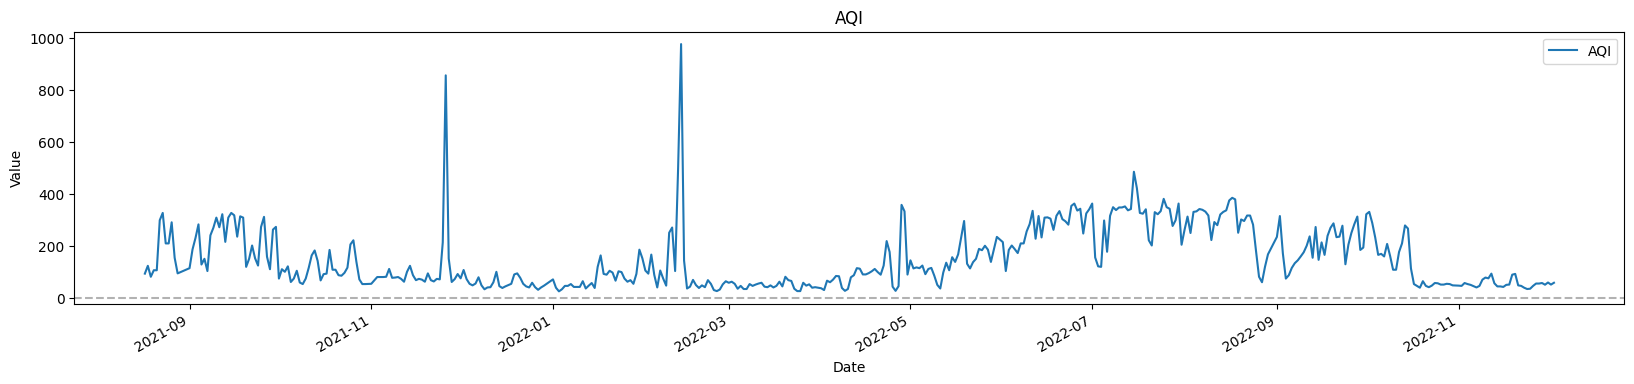

In [22]:
plot_features(aqi['AS_4'], ['AQI'], 'AQI')

In [48]:
# start date
# start_date = datetime.strptime(, "%Y-%m-%d")
# start_date
print(aqi['AS_4'].Date.iloc[-1].date())
start_date = (aqi['AS_4'].Date.iloc[-1].date() + timedelta(days=1)).isoformat()
end_date = (aqi['AS_4'].Date.iloc[-1].date() + timedelta(days=28)).isoformat()

# end_date = datetime.strptime("2022-12-31", "%Y-%m-%d")

# # difference between each date. D means one day
D = 'D'

date_list = pd.date_range(start_date, end_date, freq=D)
date_list

2022-12-03


DatetimeIndex(['2022-12-04', '2022-12-05', '2022-12-06', '2022-12-07',
               '2022-12-08', '2022-12-09', '2022-12-10', '2022-12-11',
               '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-16', '2022-12-17', '2022-12-18', '2022-12-19',
               '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',
               '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27',
               '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', freq='D')

In [96]:
# pipeline = Pipeline([
#         ("boxcox", LogEndogTransformer()),
#         ("model", AutoARIMA(start_p=7, start_q=1, d=None, max_p=10, max_q=3, max_d=1, trace=False, suppress_warnings=True, n_fits=40, n_jobs=-1))
# ])
# pipeline.fit(aqi['AS_4'].AQI)

In [97]:
# pipeline.predict(28)

In [98]:
# pipeline.predict(28)

In [ ]:
res = pd.DataFrame(columns=['ID_Date', 'AQI'])
pred_days = 28

# model_dict = dict()
# model_dict_new = dict()
model_dict_latest = dict()
for code, df in aqi.items():
    print(f"Working on {code} ...")
    
    df.dropna(inplace=True)

    pipeline = Pipeline([
        ("boxcox", LogEndogTransformer()),
        ("model", AutoARIMA(start_p=7, start_q=1, d=None, max_p=10, max_q=3, max_d=1, trace=False, suppress_warnings=True, n_fits=50, n_jobs=-1))
    ])

    pipeline.fit(df['AQI'])
    # model = AutoARIMA(df['AQI'], start_p=7, start_q=1, d=None, max_p=10, max_q=3, max_d=1, start_P=0, start_Q=0, D=0, max_P=0, max_Q=0, max_D=0, m=1, seasonal=True, \
    #        trace=False, error_action='warn', suppress_warnings=True, random_state = 42, n_fits=40, n_jobs=-1)
    # model = auto_arima(df['AQI'], trace=False, error_action='warn', suppress_warnings=True, n_fits=40, n_jobs=-1)
    
    # model_dict_latest[code] = model

    start_date = (df.Date.iloc[-1].date() + timedelta(days=1)).isoformat()
    end_date = (df.Date.iloc[-1].date() + timedelta(days=28)).isoformat()

    date_list = pd.date_range(start_date, end_date, freq='D')
    date_list = [code + '_' + str(day) for day in date_list]
    
    yhat = pipeline.predict(n_periods=pred_days)

    res = pd.concat([res, pd.DataFrame({'ID_Date': date_list, 'AQI': yhat})])
    
res.reset_index(drop=True, inplace=True)

Working on AS_4 ...
Working on DL_4 ...
Working on DL_6 ...
Working on DL_8 ...
Working on DL_12 ...
Working on DL_13 ...
Working on DL_18 ...
Working on DL_19 ...
Working on DL_21 ...
Working on DL_23 ...
Working on DL_25 ...
Working on DL_26 ...
Working on DL_27 ...
Working on DL_29 ...
Working on DL_30 ...
Working on DL_32 ...
Working on DL_35 ...
Working on DL_38 ...
Working on DL_39 ...
Working on DL_40 ...
Working on DL_41 ...
Working on KA_7 ...
Working on KA_9 ...
Working on KA_10 ...
Working on KA_11 ...


In [100]:
res.shape

(1120, 2)

In [103]:
res.ID_Date = res.ID_Date.map(lambda x: x.split()[0])
res.to_csv("submission.csv", index=False)

In [78]:
for key in model_dict.keys():
    print(key, model_dict[key].order == model_dict_latest[key].order)

AS_4 False
DL_4 True
DL_6 True
DL_8 True
DL_12 True
DL_13 False
DL_18 False
DL_19 True
DL_21 True
DL_23 True
DL_25 True
DL_26 True
DL_27 True
DL_29 True
DL_30 True
DL_32 True
DL_35 True
DL_38 True
DL_39 True
DL_40 False
DL_41 True
KA_7 True
KA_9 True
KA_10 True
KA_11 False
KA_14 True
MH_10 True
MH_11 True
MH_12 True
MH_13 True
MH_14 True
MH_15 True
MH_16 True
MH_17 True
TN_5 True
TN_8 True
WB_12 True
WB_13 True
WB_14 False
WB_16 True


In [79]:
model_dict['AS_4']

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [80]:
model_dict_latest['AS_4']

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [65]:
model = auto_arima(aqi['AS_4']['AQI'], start_p=4, start_q=1, d=None, max_p=8, max_q=3, max_d=1, start_P=0, start_Q=0, D=0, max_P=0, max_Q=0, max_D=0, m=1, seasonal=True, \
           trace=True, error_action='warn', suppress_warnings=True, random_state = 42, n_fits=40, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5330.382, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5442.598, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5426.264, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5384.037, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5440.598, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5328.383, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5330.294, Time=0.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5360.464, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5371.211, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5329.957, Time=1.70 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5358.617, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5328.666, Time=2.37 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5326.512, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0]             : 

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  464
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -2658.256
Date:                Thu, 13 Apr 2023   AIC                           5326.512
Time:                        18:46:45   BIC                           5347.201
Sample:                             0   HQIC                          5334.657
                                - 464                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4826      0.049      9.794      0.000       0.386       0.579
ar.L2         -0.1713      0.044     -3.916      0.000      -0.257      -0.086
ar.L3          0.1070      0.041      2.607      0.009       0.027       0.188
ma.L1         -0.8901      0.044    -20.288      0.000      -0.976      -0.804
sigma2      5669.7701    109.659     51.704      0.000    5454.843    5884.698
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16425.31
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model.predict(n_periods=28)

464    58.292350
465    55.895582
466    55.609511
467    55.806210
468    55.693559
469    55.574885
470    55.557967
471    55.558070
472    55.548313
473    55.541776
474    55.540304
475    55.539668
476    55.538914
477    55.538501
478    55.538363
479    55.538287
480    55.538229
481    55.538200
482    55.538187
483    55.538180
484    55.538175
485    55.538173
486    55.538172
487    55.538172
488    55.538171
489    55.538171
490    55.538171
491    55.538171
dtype: float64

(464, 2)